Comparison Between Supervised and Unsupervised Learning, and Dimentionality Reduction
---

In [2]:
# Load in pima.tr and pima.te datasets

import numpy as np
import sys
    
def load_data(f):
    """ Assume data format:
    feature1 feature 2 ... label 
    """

    # process training data
    data = np.genfromtxt(f)
    # return all feature columns except last
    X = data[:, :-1]
    y = data[:, -1].astype(int)

    return X, y


Xtrain, ytrain = load_data('python/datasets/pima.tr')
Xtest, ytest = load_data('python/datasets/pima.te')
print(f"The dimension of the training data is: {Xtrain.shape}")
print(f"The dimension of the testing data is: {Xtest.shape}")

The dimension of the training data is: (200, 7)
The dimension of the testing data is: (332, 7)


In [3]:
# Normalize pima.tr and pima.te

stds = np.std(Xtrain, axis=0)    # standard deviation along rows
means = np.mean(Xtrain, axis=0)        # mean along rows

for i in range(Xtrain.shape[0]):
    for j in range(Xtrain.shape[1]):
        Xtrain[i][j] = (Xtrain[i][j] - means[j]) / stds[j]
        
for i in range(Xtest.shape[0]):
    for j in range(Xtest.shape[1]):
        Xtest[i][j] = (Xtest[i][j] - means[j]) / stds[j]

    k-means and winner-takes-all are similiar learning algorithms in that they both use a clustering approach and are unsupervised. They both begin with k randomly located cluster centroids, then assign each sample to its closest cluster. After this, the centroids are recalculated based on the locations of the samples in each cluster and the samples are reassingned to the new centroids. This process repeats until no samples change clusters.
    However, these algorithms differ in the frequency with which they update the cluster centroids. k-means uses batch processing, which means that the centroids are only updated after each epoch is completed. One epoch is when the entire dataset has been processed once by a learning algorithm. On the other hand, winner-takes-all uses online processing. This means that after each iteration, the centroid of the cluster is recalculated. Iteration refers to the processing of each sample in a dataset.

In [408]:
# k-means and wta

import numpy as np
import math
import random
import time

def dist(xs, ys):
    length = 0
    for i in range(len(xs)):
        length += (xs[i] - ys[i])**2
    length = math.sqrt(length)
    return length

def centroid(points):
    numPoints = points.shape[0]
    centroid = np.empty(0)
    for i in range(points.shape[1]):
        centroid = np.append(centroid, np.sum(points[:, i]))
    return centroid / numPoints

# k-means
def kmeans(Xtrain, Xtest, ytest, k):
    # Find k random points within the ranges of the dataset
    mins = np.amin(Xtrain, axis=0)
    maxs = np.amax(Xtrain, axis=0)
    
    centroids = np.empty((0,Xtrain.shape[1]), float)
    for i in range(k):
        arr = np.empty((0,0), dtype=float)
        for j in range(mins.shape[0]):
            arr = np.append(arr, random.uniform(mins[j],maxs[j]))
        centroids = np.append(centroids, [arr], axis=0)
    
    # Train the model
    t0 = time.time()
    numIterationsToConverge = 0
    clusters = np.empty(Xtrain.shape[0])
    percentChange = np.array([])
    for m in range(50):
        # Assign each sample to the nearest cluster
        numChanges = 0
        for i in range(Xtrain.shape[0]):
            distances = np.empty(centroids.shape[0])
            for j in range(centroids.shape[0]):
                distances[j] = dist(Xtrain[i], centroids[j])
            if not (clusters[i] in np.where(distances == np.amin(distances))):
                clusters[i] = np.where(distances == np.amin(distances))[0]
                numChanges += 1
            numIterationsToConverge += 1
    
        # Adjust centroids
        for i in range(centroids.shape[0]):
            centroids[i] = centroid(Xtrain[clusters == i])
            
        # Remove empty clusters
        for i in range(centroids.shape[0]):
            if i not in clusters:
                centroids = np.delete(centroids, i, axis=0)
        
        percentChange = np.insert(percentChange, m, [numChanges / Xtrain.shape[0]])
        if numChanges == 0: break
            
    # Assign each cluster to the correct class
    numClass0Cluster0 = numClass0Cluster1 = 0
    for i in range(clusters.shape[0]):
        if clusters[i] == 0:
            if ytrain[i] == 0:
                numClass0Cluster0 += 1
        else:
            if ytrain[i] == 0:
                numClass0Cluster1 += 1
                
    if numClass0Cluster0 > numClass0Cluster1:
        cluster0Class = 0
        cluster1Class = 1
    else:
        cluster0Class = 1
        cluster1Class = 0
        
    t1 = time.time()
    
    # Test the model
    y = []
    for i in range(Xtest.shape[0]):
        # Assign the sample to the nearest cluster
        distances = np.empty(centroids.shape[0])
        for j in range(centroids.shape[0]):
            distances[j] = dist(Xtest[i], centroids[j])
            
        if (distances[0] < distances[1]):
            y.append(cluster0Class)
        else:
            y.append(cluster1Class)
        
    # calculate overall classification accuracy
    overallAcc = np.count_nonzero(y == ytest) / len(y)
    
    # calculate classwise accuracy
    accClass0 = accClass1 = 0
    for i in range(ytest.shape[0]):
        if ytest[i] == 0:
            if y[i] == 0:
                accClass0 += 1
        else:
            if y[i] == 1:
                accClass1 += 1
    accClass0 /= np.count_nonzero([ytest == 0])
    accClass1 /= np.count_nonzero([ytest == 1])
    
    return percentChange, overallAcc, accClass0, accClass1, numIterationsToConverge, t1-t0

# Winner-takes-all
def wta(dataset, k, learningParameter):
    # Find k random points within the ranges of the dataset
    mins = np.amin(Xtrain, axis=0)
    maxs = np.amax(Xtrain, axis=0)
    
    centroids = np.empty((0,Xtrain.shape[1]), float)
    for i in range(k):
        arr = np.empty((0,0), dtype=float)
        for j in range(mins.shape[0]):
            arr = np.append(arr, random.uniform(mins[j],maxs[j]))
        centroids = np.append(centroids, [arr], axis=0)
    
    # Train the model
    t0 = time.time()
    numIterationsToConverge = 0
    clusters = np.empty(Xtrain.shape[0])
    percentChange = np.array([])
    for m in range(50):
        # Assign each sample to the nearest cluster
        numChanges = 0
        for i in range(Xtrain.shape[0]):
            distances = np.empty(centroids.shape[0])
            for j in range(centroids.shape[0]):
                distances[j] = dist(Xtrain[i], centroids[j])
            if not (clusters[i] in np.where(distances == np.amin(distances))):
                clusters[i] = np.where(distances == np.amin(distances))[0]
                numChanges += 1
                # Adjust centroids
                centroids[int(clusters[i])] = centroids[int(clusters[i])] + learningParameter*(Xtrain[i] - centroids[int(clusters[i])])
        numIterationsToConverge += 1
    
        # Remove empty clusters
        for i in range(centroids.shape[0]):
            if i not in clusters:
                centroids = np.delete(centroids, i, axis=0)
        
        percentChange = np.insert(percentChange, m, [numChanges / Xtrain.shape[0]])
        if numChanges == 0: break
        
    # Assign each cluster to the correct class
    numClass0Cluster0 = numClass0Cluster1 = 0
    for i in range(clusters.shape[0]):
        if clusters[i] == 0:
            if ytrain[i] == 0:
                numClass0Cluster0 += 1
        else:
            if ytrain[i] == 0:
                numClass0Cluster1 += 1
                
    if numClass0Cluster0 > numClass0Cluster1:
        cluster0Class = 0
        cluster1Class = 1
    else:
        cluster0Class = 1
        cluster1Class = 0
        
    t1 = time.time()
    
    # Test the model
    y = []
    for i in range(Xtest.shape[0]):
        # Assign the sample to the nearest cluster
        distances = np.empty(centroids.shape[0])
        for j in range(centroids.shape[0]):
            distances[j] = dist(Xtest[i], centroids[j])

        if (distances[0] < distances[1]):
            y.append(cluster0Class)
        else:
            y.append(cluster1Class)
        
    # calculate overall classification accuracy
    overallAcc = np.count_nonzero(y == ytest) / len(y)
    
    # calculate classwise accuracy
    accClass0 = accClass1 = 0
    for i in range(ytest.shape[0]):
        if ytest[i] == 0:
            if y[i] == 0:
                accClass0 += 1
        else:
            if y[i] == 1:
                accClass1 += 1
    accClass0 /= np.count_nonzero([ytest == 0])
    accClass1 /= np.count_nonzero([ytest == 1])
    
    return percentChange, overallAcc, accClass0, accClass1, t1-t0, numIterationsToConverge


kmeansResults = kmeans(Xtrain, Xtest, ytest, 2)
wtaResults = wta(Xtrain, 2, 0.01)
print(kmeansResults)
print(wtaResults)

(array([0.555, 0.16 , 0.065, 0.035, 0.015, 0.005, 0.005, 0.01 , 0.005,
       0.   ]), 0.7168674698795181, 0.7064220183486238, 0.7219730941704036, 2000, 0.08350634574890137)
(array([1.   , 0.245, 0.02 , 0.   ]), 0.3102409638554217, 0.8807339449541285, 0.03139013452914798, 4, 0.02927684783935547)


Text(0.5, 1.0, 'wta')

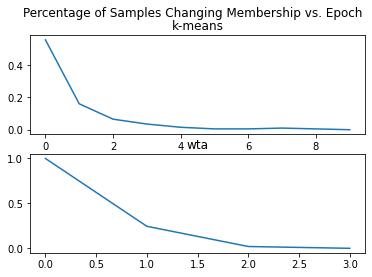

In [409]:
# Plot of "percentage of samples changing membership" vs. "epoch"

import matplotlib.pyplot as plt

fig, axs = plt.subplots(2)
fig.suptitle('Percentage of Samples Changing Membership vs. Epoch')
axs[0].plot(range(0,len(kmeansResults[0])), kmeansResults[0])
axs[0].set_title('k-means')
axs[1].plot(range(0,len(wtaResults[0])), wtaResults[0])
axs[1].set_title('wta')

In [415]:
# Case 1, Case 2, Case 3, and kNN

import numpy as np
import sys
import time
import util

def mpp(Tr, yTr, Te, yTe, cases, P):
    t0 = time.time()
    # training process - derive the model
    covs, means = {}, {}     # dictionaries
    covsum = None

    classes = np.unique(yTr)   # get unique labels as dictionary items
    classn = len(classes)    # number of classes
    
    for c in classes:
        # filter out samples for the c^th class
        arr = Tr[yTr == c]  
        # calculate statistics
        covs[c] = np.cov(np.transpose(arr))
        means[c] = np.mean(arr, axis=0)  # mean along the columns
        # accumulate the covariance matrices for Case 1 and Case 2
        if covsum is None:
            covsum = covs[c]
        else:
            covsum += covs[c]
    
    # used by case 2
    covavg = covsum / classn
    # used by case 1
    varavg = np.sum(np.diagonal(covavg)) / classn
            
    # testing process - apply the learned model on test set 
    ###y = np.zeros(classn)            # to hold labels assigned from the learned model
    y = []###
    disc = np.zeros(classn)
    nr, _ = Te.shape
    
    for i in range(nr):
        for c in classes:
            if cases == 1:
                edist2 = util.euc2(means[c], Te[i])
                disc[c] = -edist2 / (2 * varavg) + np.log(P[c])
            elif cases == 2: 
                mdist2 = util.mah2(means[c], Te[i], covavg)
                disc[c] = -mdist2 / 2 + np.log(P[c])
            elif cases == 3:
                mdist2 = util.mah2(means[c], Te[i], covs[c])
                disc[c] = -mdist2 / 2 - np.log(np.linalg.det(covs[c])) / 2 + np.log(P[c])
            else:
                print("Can only handle case numbers 1, 2, 3.")
                sys.exit(1)
        ###y[i] = disc.argmax()
        y.append(disc.argmax())
            
    t1 = time.time()
    # calculate overall classification accuracy
    overallAcc = np.count_nonzero(y == yTe) / len(y)
    
    # calculate classwise accuracy
    accClass0 = accClass1 = 0
    for i in range(yTe.shape[0]):
        if yTe[i] == 0:
            if y[i] == 0:
                accClass0 += 1
        else:
            if y[i] == 1:
                accClass1 += 1
    accClass0 /= np.count_nonzero([yTe == 0])
    accClass1 /= np.count_nonzero([yTe == 1])
    
    return overallAcc, accClass0, accClass1, t1-t0

# kNN
def calcDist(xs, ys):
    length = 0
    for i in range(len(xs)):
        length += (xs[i] - ys[i])**2
    length = math.sqrt(length)
    return length
    
def kNN(trainSet, trainSety, testSet, testSety, k):
    t0 = time.time() # starting time
    y = []

    for i in range(testSet.shape[0]):
        distances = []
        for j in range(trainSet.shape[0]):
            distances.append(calcDist(testSet[i], trainSet[j]))
        tempTrainSety = trainSety
        zipped_lists = zip(distances, tempTrainSety)
    
        sorted_pairs = sorted(zipped_lists)
        tuples = zip(*sorted_pairs)
        distances, tempTrainSety = [list(tuple) for tuple in  tuples]
        
        numClass0 = 0
        numClass1 = 0
        for l in range(k):
            if tempTrainSety[l] == 0:
                numClass0 += 1
            else:
                numClass1 += 1
                
        if numClass0 >= numClass1:
            y.append(0)
        else:
            y.append(1)
            
    t1 = time.time() # ending time

    # calculate overall classification accuracy
    overallAcc = np.count_nonzero(y == testSety) / len(y)
    
    # calculate classwise accuracy
    accClass0 = accClass1 = 0
    for i in range(testSety.shape[0]):
        if testSety[i] == 0:
            if y[i] == 0:
                accClass0 += 1
        else:
            if y[i] == 1:
                accClass1 += 1
    accClass0 /= np.count_nonzero([testSety == 0])
    accClass1 /= np.count_nonzero([testSety == 1])
    
    return overallAcc, accClass0, accClass1, t1-t0

case1Results = mpp(Xtrain, ytrain, Xtest, ytest, 1, [0.5,0.5])
case2Results = mpp(Xtrain, ytrain, Xtest, ytest, 2, [0.5,0.5])
case3Results = mpp(Xtrain, ytrain, Xtest, ytest, 3, [0.5,0.5])
kNNResults = kNN(Xtrain, ytrain, Xtest, ytest, 10)
print(case1Results)
print(case2Results)
print(case3Results)
print(kNNResults)

(0.7409638554216867, 0.7064220183486238, 0.757847533632287, 0.01425313949584961)
(0.7680722891566265, 0.7247706422018348, 0.7892376681614349, 0.01608419418334961)
(0.7530120481927711, 0.6330275229357798, 0.8116591928251121, 0.02440476417541504)
(0.7771084337349398, 0.5688073394495413, 0.8789237668161435, 0.5217070579528809)


Supervised vs. Unsupervised Learning


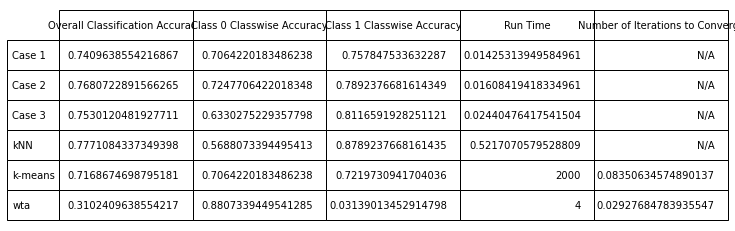

In [420]:
# Summary comparison of supervised vs. unsupervised learning

import matplotlib.pyplot as plt

print('Supervised vs. Unsupervised Learning')

cellData = [[case1Results[0], case1Results[1], case1Results[2], case1Results[3] , 'N/A'],
            [case2Results[0], case2Results[1], case2Results[2], case2Results[3], 'N/A'],
            [case3Results[0], case3Results[1], case3Results[2], case3Results[3], 'N/A'],
            [kNNResults[0], kNNResults[1], kNNResults[2], kNNResults[3], 'N/A'],
            [kmeansResults[1], kmeansResults[2], kmeansResults[3], kmeansResults[4], kmeansResults[5]],
            [wtaResults[1], wtaResults[2], wtaResults[3], wtaResults[4], wtaResults[5]]]

table1 = plt.table(cellText=cellData,
          colLabels=['Overall Classification Accuracy', 'Class 0 Classwise Accuracy', 'Class 1 Classwise Accuracy', 'Run Time', 'Number of Iterations to Converge'],
          rowLabels=['Case 1', 'Case 2', 'Case 3', 'kNN', 'k-means', 'wta'], loc='center')
ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.box(on=None)
table1.scale(2.0,2.5)
table1.auto_set_font_size(False)
table1.set_fontsize(10)

k-means:

k = 256


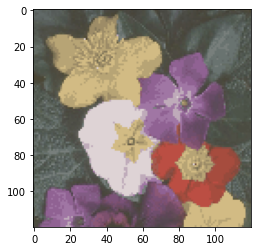

k = 128


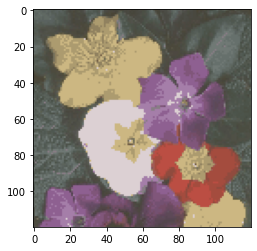

k = 64


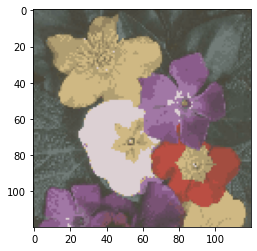

k = 32


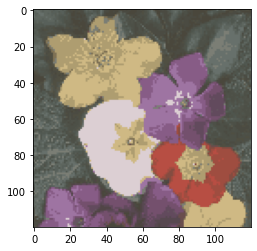

In [534]:
# k-means and wta for part 2

import numpy as np
import math
import random

def dist(xs, ys):
    length = 0
    for i in range(len(xs)):
        length += (xs[i] - ys[i])**2
    length = math.sqrt(length)
    return length

def centroid(points):
    numPoints = points.shape[0]
    centroid = np.empty(0)
    for i in range(points.shape[1]):
        centroid = np.append(centroid, np.sum(points[:, i]))
    return centroid / numPoints

# k-means
def kmeans_img(img, k):
    # Find k random points within the ranges of the dataset
    mins = np.amin(img[0], axis=0)
    maxs = np.amax(img[0], axis=0)
    
    centroids = np.empty((0,img.shape[2]), float)
    for i in range(k):
        arr = np.empty((0,0))
        for j in range(mins.shape[0]):
            arr = np.append(arr, random.uniform(mins[j],maxs[j]))
        centroids = np.append(centroids, [arr], axis=0)
    
    # Train the model
    clusters = np.zeros(img.shape[0:2])
    for m in range(10):
        # Assign each sample to the nearest cluster
        numChanges = 0
        for i in range(img.shape[0]):
            for n in range(img.shape[1]):
                distances = np.empty(centroids.shape[0])
                for j in range(centroids.shape[0]):
                    distances[j] = dist(img[i][n], centroids[j])
                if not np.all(clusters[i][n] in np.where(distances == np.amin(distances))):
                    clusters[i][n] = np.where(distances == np.amin(distances))[0]
                    numChanges += 1
        
        # Adjust centroids
        for i in range(centroids.shape[0]):
            pointsInCluster = np.empty((0, 3))
            for j in range(clusters.shape[0]):
                for l in range(clusters.shape[1]):
                    if (clusters[j][l] == i):
                        pointsInCluster = np.vstack((pointsInCluster, img[j][l]))
            if pointsInCluster.size == 0:
                if i >= centroids.shape[0]: break
                else: centroids = np.delete(centroids, i, 0)
            else:
                if i >= centroids.shape[0]: break
                else: centroids[i] = centroid(pointsInCluster)
        
        if numChanges == 0: break
            
    # Return new image
    newImg = np.empty(img.shape)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            newImg[i][j] = centroids[int(clusters[i][j])]
            
    return newImg.astype(int)
        
       
print('k-means:\n')
print('k = 256')
newImg_256 = kmeans_img(img, 256)
newImg_256 = np.reshape(newImg_256, (m, n, k))
plt.imshow(newImg_256)
plt.show()
print('k = 128')
newImg_128 = kmeans_img(img, 128)
newImg_128 = np.reshape(newImg_128, (m, n, k))
plt.imshow(newImg_128)
plt.show()
print('k = 64')
newImg_64 = kmeans_img(img, 64)
newImg_64 = np.reshape(newImg_64, (m, n, k))
plt.imshow(newImg_64)
plt.show()
print('k = 32')
newImg_32 = kmeans_img(img, 32)
newImg_32 = np.reshape(newImg_32, (m, n, k))
plt.imshow(newImg_32)
plt.show()

    The above images show the results of k-means on the same original image file. The top image shows the result of k = 256 clusters, meaning that only 256 colors are used in the image. The next images show k = 128, 64, and 32 clusters respectively. Surprisingly, I notice very little change between the images with the naked eye. In fact, the colors all look to be about the same to me, the only difference is that the images with fewer colors appear to be slightly more pixelated. This tells me that most people probably don't recognize the slight variations in hues in a typical image. However, with less colors as options, the change from one color to another seems more stark and less blended than it would if all available colors were used.
        These results lead me to believe that if a learning algorithm were to use pictures as input, there would most likely be little to no downside if some of the colors were removed. In fact, removing some of the color options may in turn reduce the amount of noise.

k = 128


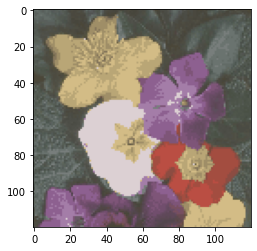

In [535]:
print('k = 128')
newImg_128 = kmeans_img(img, 128)
newImg_128 = np.reshape(newImg_128, (m, n, k))
plt.imshow(newImg_128)
plt.show()

k = 64


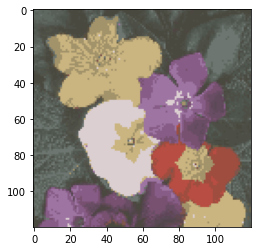

In [536]:
print('k = 64')
newImg_64 = kmeans_img(img, 64)
newImg_64 = np.reshape(newImg_64, (m, n, k))
plt.imshow(newImg_64)
plt.show()

k = 32


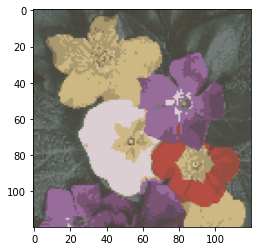

In [537]:
print('k = 32')
newImg_32 = kmeans_img(img, 32)
newImg_32 = np.reshape(newImg_32, (m, n, k))
plt.imshow(newImg_32)
plt.show()

Implement PCA:

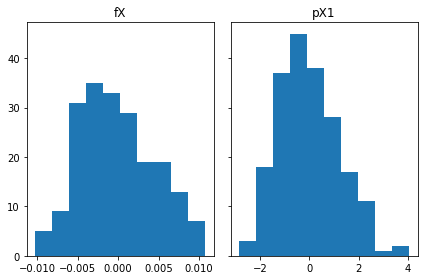

Error rate introduced by pX1 is 0.34418016724501216


In [4]:
# PCA

import numpy as np
import matplotlib.pyplot as plt

arr = Xtrain[ytrain == 0]       # get training samples for class 0
covs0 = np.cov(np.transpose(arr))    # calculate Sigma
means0 = np.mean(arr, axis=0)        # mean along rows

arr = Xtrain[ytrain == 1]       # get training samples for class 1
covs1 = np.cov(np.transpose(arr))    # calculate Sigma
means1 = np.mean(arr, axis=0)        # mean along rows

S_0 = (Xtrain.shape[0] - 1) * covs0 # (n - 1) * Sigma
S_1 = (Xtrain.shape[0] - 1) * covs1 # (n - 1) * Sigma
S_w = np.add(S_0, S_1)

w = np.dot(np.linalg.inv(S_w), np.subtract(means0, means1)) # w = inverse(S_w) * (means0 - means1)

nX = Xtrain
fX = np.empty(nX.shape[0])
for i in range(nX.shape[0]):
    fX[i] = np.dot(np.transpose(w), nX[i])

#print(f'fX: {fX}')
#print(fX.shape)

covsAll = np.cov(np.transpose(Xtrain))    # calculate sigma
eigenvalues, eigenvectors = np.linalg.eig(covsAll)    # calculate eigenvalues, eigenvectors
#print(f'eigenvalues: {eigenvalues}')
#print(f'eigenvectors: {eigenvectors}')

eigenvalueMax = 0
eigenvectorMax = []
for i in range(eigenvalues.shape[0]):
    if eigenvalues[i] > eigenvalueMax:
        eigenvalueMax = eigenvalues[i]
        eigenvectorMax = eigenvectors[i]
        
pX1 = np.empty(nX.shape[0])
for i in range(nX.shape[0]):
    pX1[i] = np.dot(np.transpose(eigenvectorMax), nX[i])
    
#print(f'pX1: {pX1}')
#print(pX1.shape)

# Plot results
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
axs[0].hist(fX)
axs[1].hist(pX1)
axs[0].title.set_text('fX')
axs[1].title.set_text('pX1')
plt.show()

print(f'Error rate introduced by pX1 is {eigenvalueMax / np.sum(eigenvalues)}')

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# If error rate is 15%, how many eigenvctors are kept?
sortedEigenvalues = np.sort(eigenvalues)
print(f'Error reate of removing one eigenvector is {sortedEigenvalues[0] / np.sum(eigenvalues)}')
print(f'Error reate of removing two eigenvectors is {(sortedEigenvalues[0] + sortedEigenvalues[1]) / np.sum(eigenvalues)}')
print(f'Error reate of removing three eigenvectors is {(sortedEigenvalues[0] + sortedEigenvalues[1] + sortedEigenvalues[2]) / np.sum(eigenvalues)}')
print('If the error rate is 15%, 5 dimentions need to be kept.')

Error reate of removing one eigenvector is 0.043214115261385334
Error reate of removing two eigenvectors is 0.09890249052449859
Error reate of removing three eigenvectors is 0.19749323339975364
If the error rate is 15%, 5 dimentions need to be kept.


    In this project, I used k-means and wta as clustering algorithms in order to compare supervised and unsupervised learning approaches. I also utilized k-means as a sort of compression algorithm to reduce the possible colors of an image. The second half of this project involved using PCA for dimentionality reduction over the pima dataset. The dataset still appeared to be represented fairly well, and choosing how many eigenvectors to use with PCA gives a lot of control over how much error to allow in a learning algorithm. Overall I have developed a better understanding of both unsupervised learning algorithms and dimentionality reduction. 